<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/Covid-detect/scratch_cnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip

In [3]:
#!pip install split-folders
import splitfolders
splitfolders.ratio("/content/COVID-19 Radiography Database", output="Data", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 3886 files [00:04, 907.97 files/s] 


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
train_path = '/content/Data/train'
#test_path = '/content/test'
valid_path = '/content/Data/val'

In [6]:

#Define standard parameter values
batch_size = 32
img_height = 500
img_width = 500


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
                                      )

# test = test_data_gen.flow_from_directory(
#       test_path,
#       target_size=(img_height, img_width),
#       color_mode='grayscale',shuffle=False,
#       class_mode='binary',
#       batch_size=batch_size
#       )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',shuffle=False,
      class_mode='categorical', 
      batch_size=batch_size
      )

Found 3108 images belonging to 3 classes.
Found 778 images belonging to 3 classes.


In [10]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [12]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.3))
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dropout(0.1))
cnn.add(Dense(activation = 'softmax', units = 3))


cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 58, 58, 64)       

In [14]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.0001)

callbacks_list = [ early, learning_rate_reduction]

In [15]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [16]:
cnn.fit(train,epochs=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/20
98/98 [==============================] - 242s 2s/step - loss: 0.9821 - accuracy: 0.4687 - val_loss: 0.4316 - val_accuracy: 0.8252
Epoch 2/20
98/98 [==============================] - 210s 2s/step - loss: 0.4005 - accuracy: 0.8515 - val_loss: 0.2836 - val_accuracy: 0.9062
Epoch 3/20
98/98 [==============================] - 212s 2s/step - loss: 0.3267 - accuracy: 0.8876 - val_loss: 0.2796 - val_accuracy: 0.9010
Epoch 4/20
98/98 [==============================] - 212s 2s/step - loss: 0.3148 - accuracy: 0.8939 - val_loss: 0.2799 - val_accuracy: 0.9113
Epoch 5/20
98/98 [==============================] - 213s 2s/step - loss: 0.2734 - accuracy: 0.9088 - val_loss: 0.2911 - val_accuracy: 0.9049

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/20
98/98 [==============================] - 214s 2s/step - loss: 0.2320 - accuracy: 0.9258 - val_loss: 0.2026 - val_accuracy: 0.9383
Epoch 7/20
98/98 [==============================] - 215s 2s/step - loss:

In [28]:
cnn.evaluate(train)

98/98 [==============================] - 192s 2s/step - loss: 0.1577 - accuracy: 0.9424


[0.15766188502311707, 0.9424067139625549]

In [30]:
from keras.models import load_model
cnn.save('3_class_scratch_acc94.h5')
cnn.evaluate(valid)


25/25 [==============================] - 12s 498ms/step - loss: 0.1732 - accuracy: 0.9434


[0.17323654890060425, 0.9434447288513184]

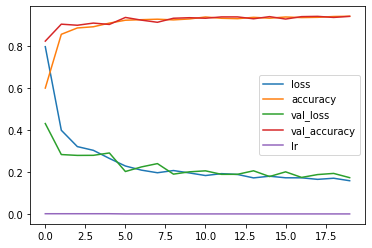

In [17]:
pd.DataFrame(cnn.history.history).plot()

In [19]:
preds = cnn.predict(valid,verbose=1)

25/25 [==============================] - 12s 503ms/step


In [20]:
preds

array([[9.9999297e-01, 2.7397400e-07, 6.7899969e-06],
       [9.9949384e-01, 4.0886545e-04, 9.7253964e-05],
       [9.9742824e-01, 2.4014052e-03, 1.7036885e-04],
       ...,
       [9.4917966e-03, 7.0919530e-03, 9.8341620e-01],
       [4.4361273e-05, 5.4860732e-04, 9.9940705e-01],
       [2.7229907e-03, 7.8632766e-01, 2.1094930e-01]], dtype=float32)

In [24]:
predictions = preds.copy()
predictions = np.argmax(predictions,axis=1)
# predictions[predictions <= 0.5] = 0
# predictions[predictions > 0.5] = 1


In [25]:
print(train.class_indices)
predictions

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

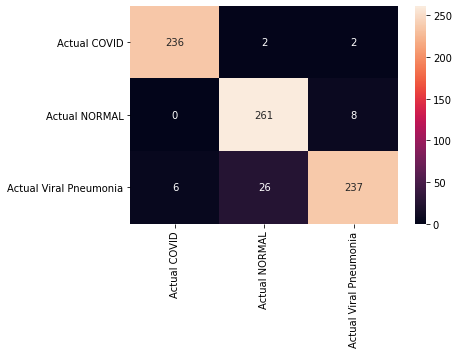

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(valid.classes, predictions, labels=[0, 1, 2]),
                  index=["Actual COVID", "Actual NORMAL", "Actual Viral Pneumonia"],
                  columns=["Actual COVID", "Actual NORMAL", "Actual Viral Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [27]:
 print(classification_report(y_true=valid.classes, y_pred=predictions,
                            target_names =['COVID','NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       240
      NORMAL       0.90      0.97      0.94       269
   PNEUMONIA       0.96      0.88      0.92       269

    accuracy                           0.94       778
   macro avg       0.95      0.94      0.94       778
weighted avg       0.94      0.94      0.94       778

